# Data Preprocessing

Before we train the CBA and CMAR classifier, we should preprocess the dataset so that it only contains categorical features as both models only support categorical variables. We will use feature discretization (binning) to convert continuous variables into categorical values.

In [1]:
# Import necessary packages
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# ignore all warnings
warnings.filterwarnings('ignore')

# get dataset path
curr_work_dir = os.getcwd()
print(curr_work_dir)

dataset_dir = os.path.join(curr_work_dir, "..", "datasets/raw")
save_dir = os.path.join(curr_work_dir, "..", "datasets/processed")

/home/user/Rule_Based_Classification/notebooks


## 1. Iris Dataset

First, we will look at Iris dataset (found in this link: [https://archive.ics.uci.edu/ml/datasets/iris](https://archive.ics.uci.edu/ml/datasets/iris)). 

### Data Visualization

In [2]:
# load dataset
header_names = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
iris_data = pd.read_csv(os.path.join(dataset_dir, "iris.data"), names = header_names)

iris_data.head(10)

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


From this we can see that **sepal_length**, **sepal_width**, **petal_length**, and **petal_width** are continuous variables, also the last column is the target class. 

In [3]:
cont_feat = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
X_cont = iris_data[cont_feat]
y = iris_data["class"]

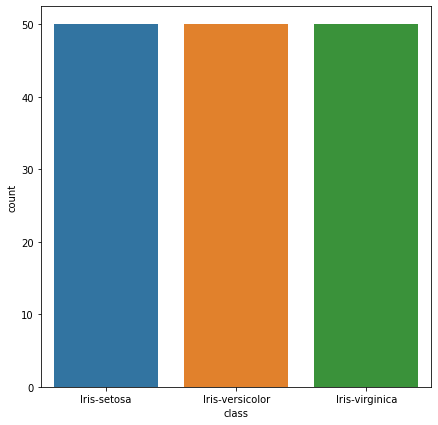

Number of Iris-setosa:  50
Number of Iris-versicolor:  50
Number of Iris-virginica:  50


In [4]:
# see class distribution
plt.figure(figsize=(7,7))
sns.countplot(y, label = "Count")
plt.show()

setosa, versicolor, virginica = y.value_counts()
print("Number of Iris-setosa: ", setosa)
print("Number of Iris-versicolor: ", versicolor)
print("Number of Iris-virginica: ", virginica)

In [5]:
X_cont.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


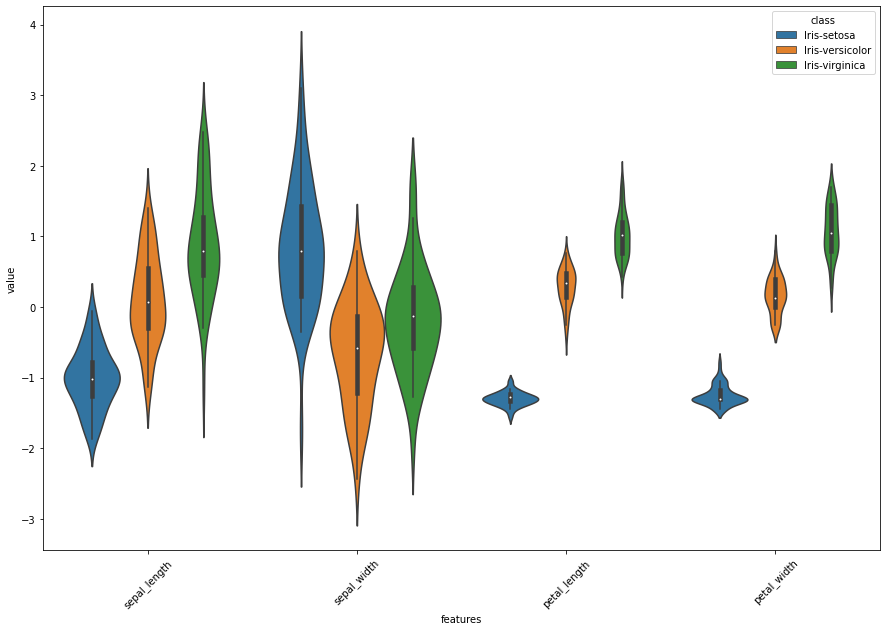

In [6]:
# violin plot
X_norm = (X_cont - X_cont.mean()) / X_cont.std()
data = pd.concat([y, X_norm], axis = 1)
data = pd.melt(data, id_vars = "class", var_name = "features", value_name = "value") # unpivot the data

plt.figure(figsize = (15, 10))
sns.violinplot(x = "features", y = "value", hue = "class", data = data)
plt.xticks(rotation = 45)
plt.show()

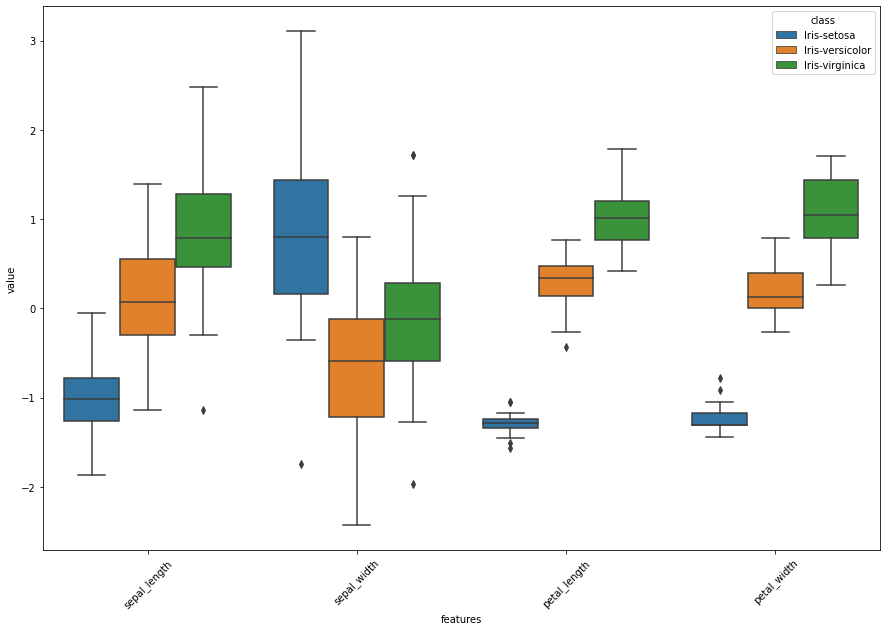

In [7]:
plt.figure(figsize=(15,10))
sns.boxplot(x = "features", y = "value", hue = "class", data = data)
plt.xticks(rotation = 45)
plt.show()

From violin and boxplot above, we can see that **petal_length** and **petal_width** are important features to classify Iris-setosa (the distribution values are much lower than the others). However, we can also see that **sepal_length**, **petal_length**, and **petal_width** are pretty similar (Iris-setosa on the bottom, versicolor on the middle, and virginica on the upper level). We will see whether these features have high correlation.

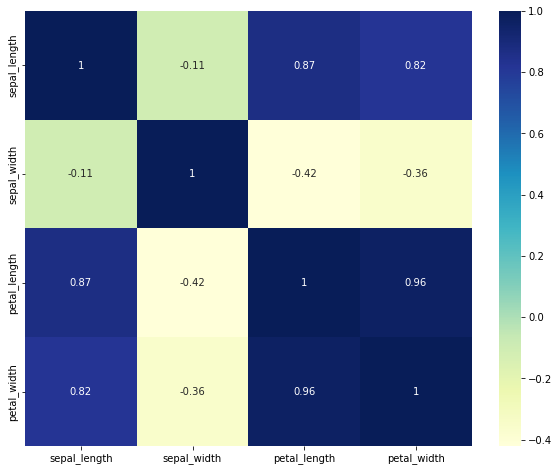

In [8]:
# heatmap (correlation)
plt.figure(figsize=(10,8))
sns.heatmap(X_cont.corr(), cmap="YlGnBu", annot = True)
plt.show()

From correlation above, we can see that those three features indeed have high correlations. Most of the times, we should remove the highly (positive or negative) correlated features. If we take a look into the violin and boxplot, it is better to keep the **petal_length** or **petal_width** as they are better at classifying Iris-setosa.

### Feature Selection & Discretization

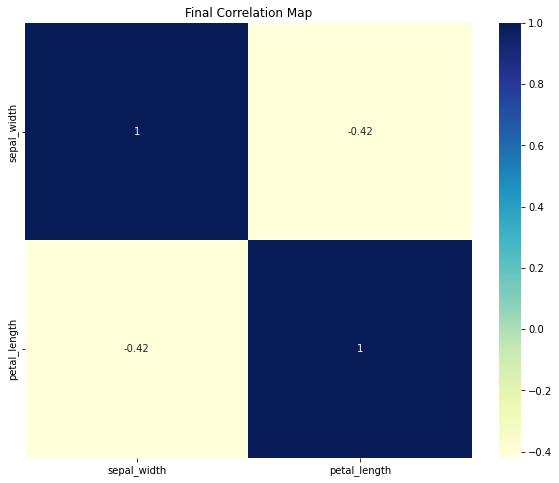

In [9]:
# keep petal_length and drop petal_width and sepal_length
drop_column = ["sepal_length", "petal_width"]
X_drop = X_cont.drop(drop_column, axis = 1)

plt.figure(figsize=(10,8))
sns.heatmap(X_drop.corr(), cmap="YlGnBu", annot = True)
plt.title("Final Correlation Map")
plt.show()

There a lot of ways to do feature discretization, in this notebook we mainly use **equal-width** and **equal-depth** (frequency) method. If we look at **petal_length** feature, equal-depth method seems more reasonable choice since there are some gaps between Iris-setosa, Iris-versicolor, and Iris-virginica. For **sepal_width** we will also use equal-depth method.

In [10]:
def equal_width_binning(arr, nbins = 5):
    width = (arr.max() - arr.min()) / nbins
    bins = []
    
    b = arr.min() + width
    while b < arr.max():
        bins.append(b)
        b += width
    
    return np.digitize(arr, bins, right=False)


def equal_depth_binning(arr, nbins = 5):
    depth = len(arr) / nbins
    
    arr_sort = sorted(arr)
    bins = []
    idx = depth
    while idx < len(arr_sort):
        bins.append(arr_sort[int(idx)])
        idx += depth
    
    return np.digitize(arr, bins, right=False)

In [11]:
# try using equal_width_binning for experiment
X_disc = X_drop.copy()
X_disc["sepal_width"] = equal_depth_binning(X_disc["sepal_width"], nbins = 6)
X_disc["petal_length"] = equal_depth_binning(X_disc["petal_length"], nbins = 6)
X_disc.head(10)

,sepal_width,petal_length
0,5,0
1,3,0
2,4,0
3,3,1
4,5,0
5,5,1
6,5,0
7,5,1
8,2,0
9,3,1


In [12]:
# save the processed dataset
processed = pd.concat([X_disc, y], axis = 1)
processed.to_csv(os.path.join(save_dir, "iris_processed.csv"), index = False)

## 2. Wine Dataset

The dataset can be found in this link [https://archive.ics.uci.edu/ml/datasets/wine](https://archive.ics.uci.edu/ml/datasets/wine).

### Data Visualization

In [13]:
# load dataset
header_names = [
    "class",
    "Alcohol", 
    "Malic acid",
    "Ash",
    "Alcalinity of ash",  
    "Magnesium",
    "Total phenols",
    "Flavanoids",
    "Nonflavanoid phenols",
    "Proanthocyanins",
    "Color intensity",
    "Hue",
    "OD280/OD315 of diluted wines",
    "Proline"
]
wine_data = pd.read_csv(os.path.join(dataset_dir, "wine.data"), names = header_names, index_col = False)
wine_data.head()

,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


From the dataset, we can see that the first column is the target class. Remaining columns are continuous variables that we want to apply discretization.

In [14]:
# see class distribution
y = wine_data["class"]
X_cont = wine_data.drop(["class"], axis = 1)

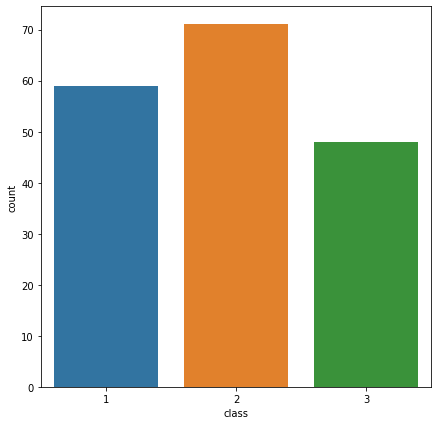

Number of class 1:  59
Number of class 2:  71
Number of class 3:  48


In [15]:
plt.figure(figsize=(7,7))
sns.countplot(y)
plt.show()

wine_1, wine_2, wine_3 = y.value_counts().sort_index()
print("Number of class 1: ", wine_1)
print("Number of class 2: ", wine_2)
print("Number of class 3: ", wine_3)

In [16]:
X_cont.describe()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


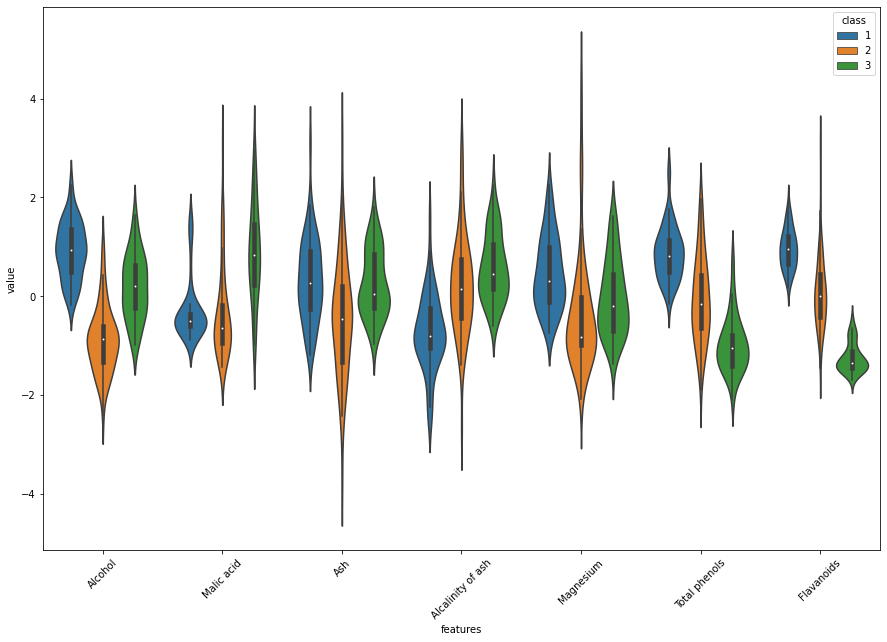

In [17]:
# violin plot for first seven features
X_norm = (X_cont - X_cont.mean()) / X_cont.std()
data = pd.concat([y, X_norm.iloc[:, :7]], axis = 1)
data = pd.melt(data, id_vars = "class", var_name = "features", value_name = "value")

fig = plt.figure(figsize = (15, 10))
sns.violinplot(x = "features", y = "value", hue = "class", data = data)
plt.xticks(rotation = 45)
plt.show()

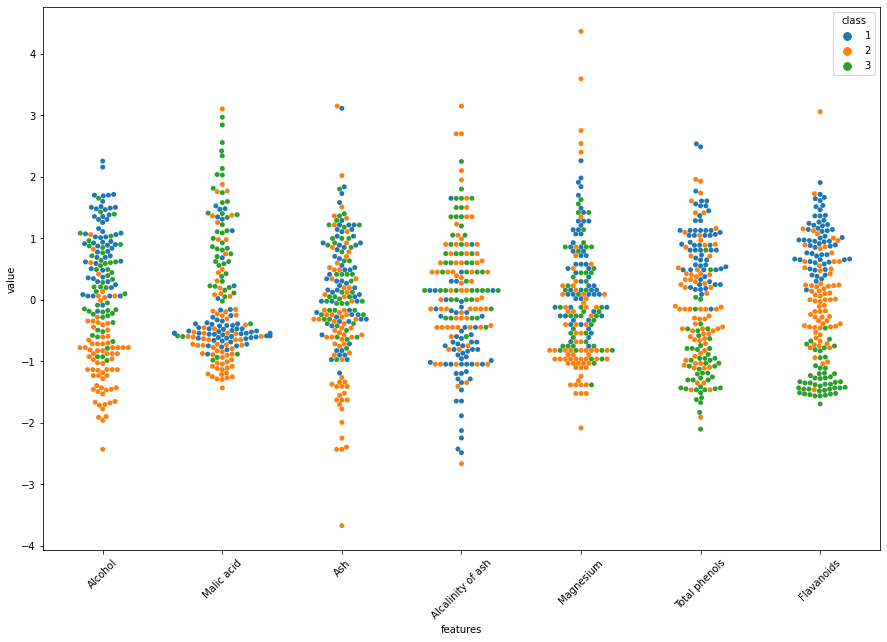

In [18]:
# swarmplot first seven features
X_norm = (X_cont - X_cont.mean()) / X_cont.std()
data = pd.concat([y, X_norm.iloc[:, :7]], axis = 1)
data = pd.melt(data, id_vars = "class", var_name = "features", value_name = "value")

fig = plt.figure(figsize = (15,10))
sns.swarmplot(x = "features", y = "value", hue = "class", data = data)
plt.xticks(rotation = 45)
plt.show()

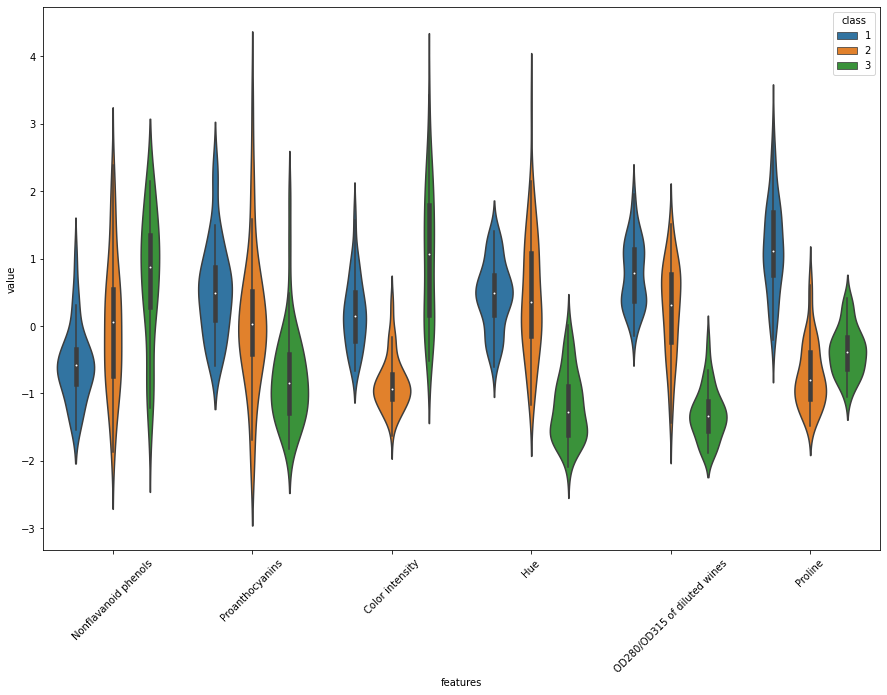

In [19]:
# last 6 features
X_norm = (X_cont - X_cont.mean()) / X_cont.std()
data = pd.concat([y, X_norm.iloc[:, 7:]], axis = 1)
data = pd.melt(data, id_vars = "class", var_name = "features", value_name = "value")

fig = plt.figure(figsize=(15, 10))
sns.violinplot(x = "features", y = "value", hue = "class", data = data)
plt.xticks(rotation = 45)
plt.show()

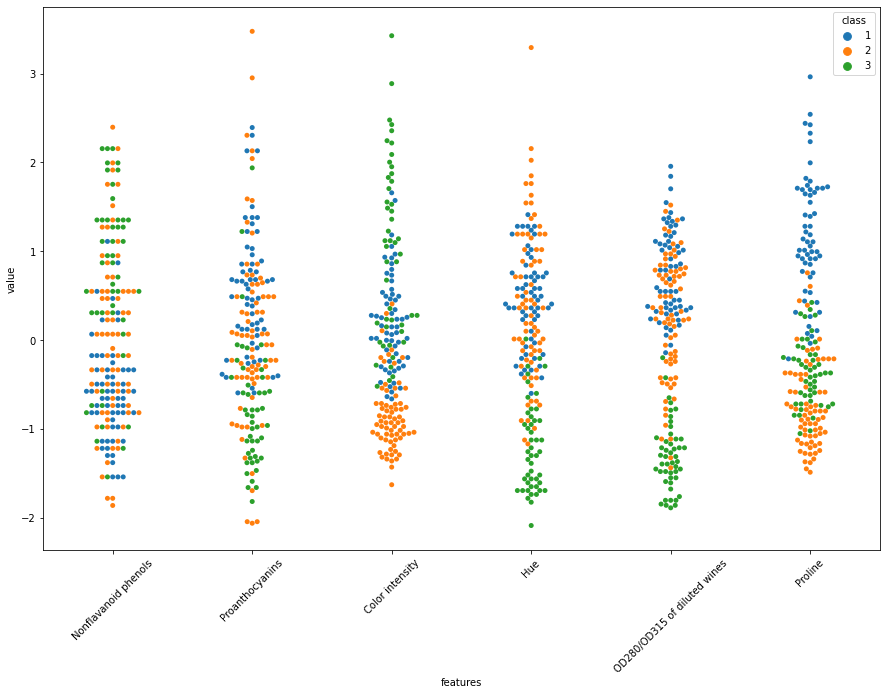

In [20]:
# swarmplot last 6 features
X_norm = (X_cont - X_cont.mean()) / X_cont.std()
data = pd.concat([y, X_norm.iloc[:, 7:]], axis = 1)
data = pd.melt(data, id_vars = "class", var_name = "features", value_name = "value")

fig = plt.figure(figsize = (15,10))
sns.swarmplot(x = "features", y = "value", hue = "class", data = data)
plt.xticks(rotation = 45)
plt.show()

From violinplot and swarmplot above, we can see that **Flavanoid** may be one of the most important features as we can easily distinguish distribution of wine1, wine2, and wine3. We can also see that **Color intensity** may be important for classifying wine2. Aside from that, we also found that every feature is not similar from each other. Therefore, the correlations of most features will be pretty low.

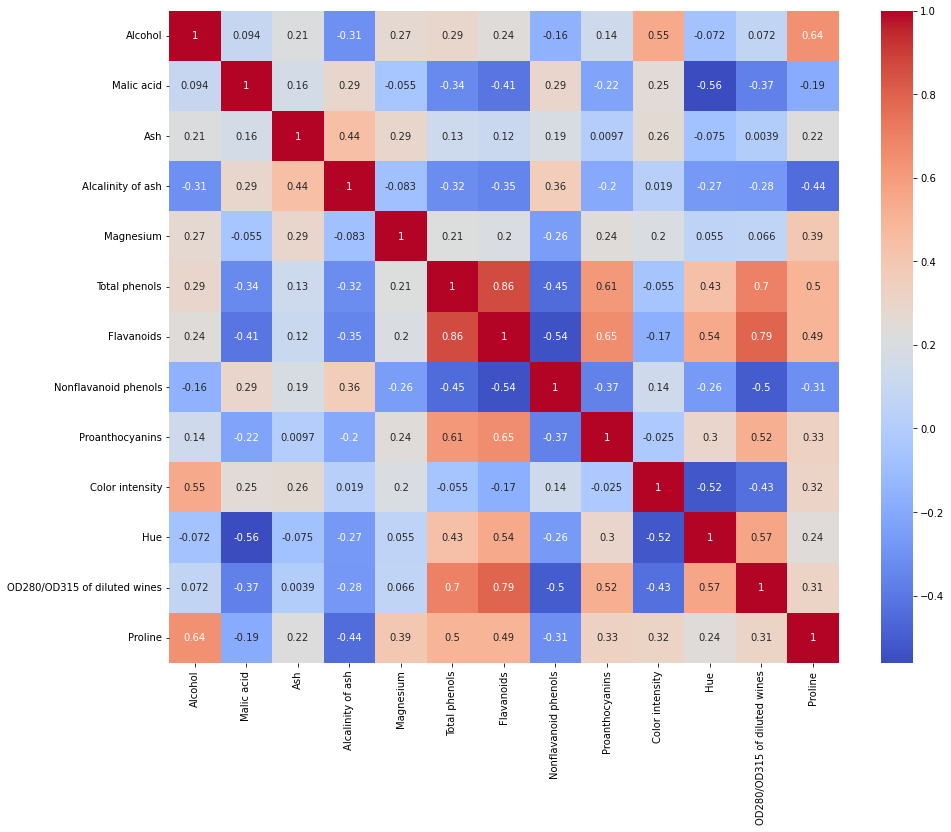

In [21]:
# heatmap
fig = plt.figure(figsize=(15, 12))
sns.heatmap(X_cont.corr(), annot = True, cmap="coolwarm")
plt.xticks(rotation = 90)
plt.show()

Most features are not correlated to each other. There are some exceptions, like **Flavanoids**, **Total phenols**, and **OD280/OD315 of diluted wines**. We will perform feature selection on the next section.

### Feature Selection & Discretization

We will select **Flavonoids** from correlated features {**Flavonoids**, **Total phenols**, and **OD280/OD315 of diluted wines**}. This is because we observed from swarmplot that **Flavonoids** gives the best distribution.

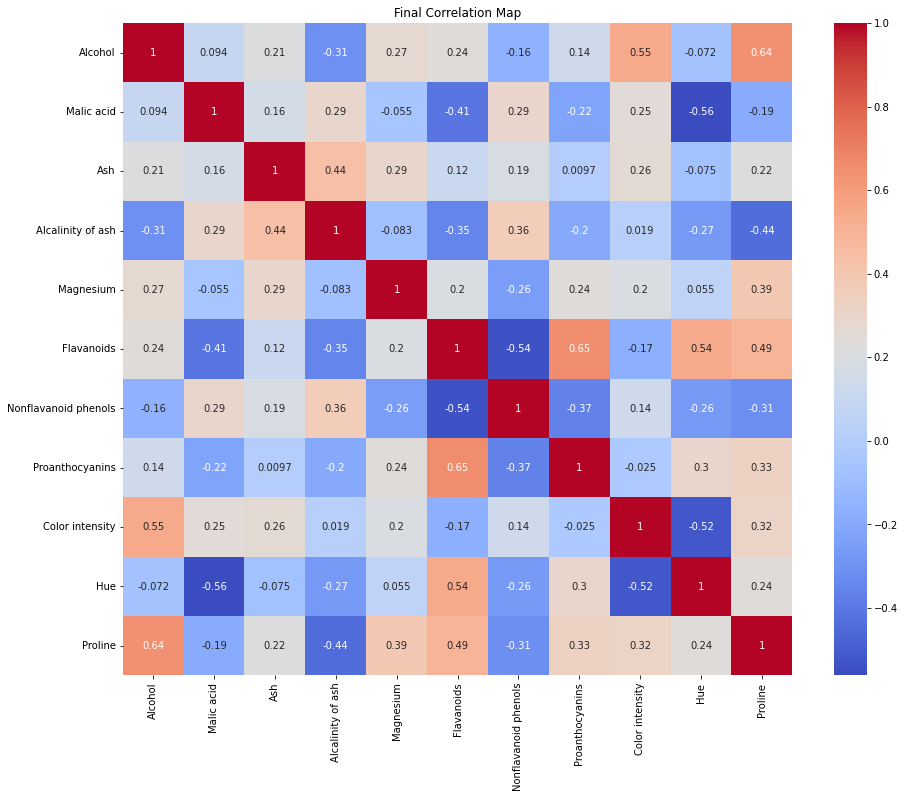

In [22]:
drop_cols = ["Total phenols", "OD280/OD315 of diluted wines"]
X_drop = X_cont.drop(drop_cols, axis = 1)

# final correlation map
plt.figure(figsize=(15,12))
sns.heatmap(X_drop.corr(), cmap="coolwarm", annot = True)
plt.title("Final Correlation Map")
plt.show()

Now, we will perform feature discretization using **equal-depth method**. The reason is that most features have several outliers (can be seen on the swarmplot above) which may cause some problems if we use equal-width method.

In [23]:
def equal_width_binning(arr, nbins = 5):
    width = (arr.max() - arr.min()) / nbins
    bins = []
    
    b = arr.min() + width
    while b < arr.max():
        bins.append(b)
        b += width
    
    return np.digitize(arr, bins, right=False)


def equal_depth_binning(arr, nbins = 5):
    depth = len(arr) / nbins
    
    arr_sort = sorted(arr)
    bins = []
    idx = depth
    while idx < len(arr_sort):
        bins.append(arr_sort[int(idx)])
        idx += depth
    
    return np.digitize(arr, bins, right=False)

In [24]:
# discretization
X_disc = X_drop.copy()
for col in X_disc.columns:
    X_disc[col] = equal_depth_binning(X_disc[col], nbins = 7)
X_disc.head(10)

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,Proline
0,6,2,4,0,6,5,2,6,4,4,5
1,4,3,1,0,3,5,1,2,3,4,5
2,3,4,6,2,4,6,2,6,4,4,6
3,6,3,4,1,5,6,1,6,6,2,6
4,4,4,6,5,6,4,4,4,2,4,4
5,6,3,4,0,5,6,3,5,5,4,6
6,6,3,4,0,3,4,2,5,4,3,6
7,6,4,5,2,6,4,3,1,3,4,6
8,7,2,1,0,3,5,2,5,4,4,5
9,5,1,2,1,3,6,0,4,5,3,5


In [25]:
# save the processed data
processed = pd.concat([X_disc, y], axis = 1)
processed.to_csv(os.path.join(save_dir, "wine_processed.csv"), index = False)

### 3. Breast Cancer Dataset

Let's take a look on bigger dataset, Breast Cancer dataset (found in this link: [https://www.kaggle.com/uciml/breast-cancer-wisconsin-data](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data)).

In [29]:
bcancer_data = pd.read_csv(os.path.join(dataset_dir, "breast_cancer.csv"))
bcancer_data.head(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,NaN
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,NaN
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,NaN
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,NaN
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,NaN
